In [ ]:
from bertopic import BERTopic
import numpy as np
import pandas as pd
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import datetime
import nltk
from nltk.corpus import stopwords
import logging
import os
from dotenv import load_dotenv
from umap import UMAP
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import openai
import spacy
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from sklearn.metrics import silhouette_score
import os
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# Auxiliary Functions

In [2]:
def auto_save_figure(fig, figure_name, save_formats=['png'], 
                    width=1000, height=700, scale=2, output_dir="../../outputs/plots"):
    """
    Automatically save any Plotly or Matplotlib figure to disk with multiple formats and timestamp
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The figure to save (supports both Plotly and Matplotlib)
    figure_name : str
        Descriptive name for the figure (will be used in filename)
    save_formats : list
        List of formats to save ['png', 'html', 'pdf', 'svg', 'jpeg']
    width : int
        Width of the saved image
    height : int
        Height of the saved image
    scale : int
        Scale factor for image resolution (higher = better quality)
    output_dir : str
        Directory to save the figures
    
    Returns:
    --------
    dict : Dictionary with saved file paths
    """
    if fig is None:
        print(f"❌ No figure provided for '{figure_name}'")
        return {}
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = {}
    
    # Detect figure type
    is_plotly = hasattr(fig, 'write_image') and hasattr(fig, 'write_html')
    is_matplotlib = hasattr(fig, 'savefig')
    
    if not is_plotly and not is_matplotlib:
        print(f"❌ Unsupported figure type for '{figure_name}': {type(fig)}")
        return {}
    
    for format_type in save_formats:
        # Clean figure name for filename (remove spaces, special chars)
        clean_name = "".join(c for c in figure_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
        clean_name = clean_name.replace(' ', '_').lower()
        
        filename = f"{timestamp}_{clean_name}.{format_type}"
        filepath = os.path.join(output_dir, filename)
        
        try:
            if is_plotly:
                # Handle Plotly figures
                if format_type == 'html':
                    fig.write_html(filepath)
                    print(f"📊 Saved {figure_name} as HTML: {filename}")
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    fig.write_image(
                        filepath,
                        width=width,
                        height=height,
                        scale=scale,
                        format=format_type
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
                    
            elif is_matplotlib:
                # Handle Matplotlib figures
                if format_type == 'html':
                    # Convert matplotlib to HTML via mpld3 (if available) or skip
                    try:
                        import mpld3
                        html_str = mpld3.fig_to_html(fig)
                        with open(filepath, 'w') as f:
                            f.write(html_str)
                        print(f"📊 Saved {figure_name} as HTML: {filename}")
                    except ImportError:
                        print(f"⚠️  Skipping HTML for matplotlib figure '{figure_name}' (mpld3 not available)")
                        continue
                elif format_type in ['png', 'pdf', 'svg', 'jpeg']:
                    # Set DPI based on scale
                    dpi = 100 * scale
                    fig.savefig(
                        filepath,
                        format=format_type,
                        dpi=dpi,
                        bbox_inches='tight',
                        facecolor='white',
                        edgecolor='none'
                    )
                    print(f"🖼️  Saved {figure_name} as {format_type.upper()}: {filename}")
            
            saved_files[format_type] = os.path.abspath(filepath)
            
        except Exception as e:
            print(f"❌ Error saving {figure_name} as {format_type}: {e}")
    
    if saved_files:
        print(f"✅ Total saved: {len(saved_files)} file(s) for '{figure_name}'")
        print(f"📁 Location: {os.path.abspath(output_dir)}")
        print("-" * 60)
    
    return saved_files

In [3]:
def enhance_bertopic_figure(fig, viz_type):
    """
    Enhance BERTopic figures with specific optimizations for each visualization type
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        The BERTopic figure to enhance
    viz_type : str
        Type of visualization ('topics', 'topics_per_class', 'heatmap', etc.)
    
    Returns:
    --------
    plotly.graph_objects.Figure : Enhanced figure
    """
    if fig is None:
        return fig
        
    try:
        if viz_type == 'topics':
            # Fix intertopic distance map cropping issues
            fig.update_layout(
                # Increase margins to prevent cropping
                margin=dict(l=80, r=80, t=100, b=80),
                # Ensure proper aspect ratio
                width=1200,
                height=900,
                # Add padding to prevent cluster cutoff
                xaxis=dict(
                    range=None,  # Let plotly auto-scale
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                yaxis=dict(
                    range=None,  # Let plotly auto-scale  
                    automargin=True,
                    showgrid=True,
                    gridcolor='rgba(0,0,0,0.1)'
                ),
                # Improve title positioning
                title=dict(
                    x=0.5,
                    xanchor='center',
                    y=0.95,
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'topics_per_class':
            # Ensure all topics are visible (not just the first one)
            # Make all traces visible by default
            if hasattr(fig, 'data'):
                for trace in fig.data:
                    trace.visible = True
                    
            # Improve layout for topics per class
            fig.update_layout(
                margin=dict(l=60, r=60, t=120, b=60),
                width=1200,
                height=800,
                # Ensure legend is visible and functional
                showlegend=True,
                legend=dict(
                    orientation="v",
                    yanchor="top",
                    y=1,
                    xanchor="left",
                    x=1.02,
                    bgcolor='rgba(255,255,255,0.8)',
                    bordercolor='rgba(0,0,0,0.3)',
                    borderwidth=1
                ),
                # Improve title
                title=dict(
                    x=0.5,
                    xanchor='center',
                    font=dict(size=16)
                )
            )
            
        elif viz_type == 'heatmap':
            # Optimize heatmap layout
            fig.update_layout(
                margin=dict(l=120, r=80, t=100, b=120),
                width=1000,
                height=700
            )
            
        elif viz_type == 'document_datamap':
            # Optimize document datamap
            fig.update_layout(
                margin=dict(l=80, r=80, t=100, b=80),
                width=1200,
                height=900
            )
            
        elif viz_type == 'hierarchy':
            # Optimize hierarchy plot
            fig.update_layout(
                margin=dict(l=100, r=100, t=100, b=100),
                width=1400,
                height=800
            )
            
    except Exception as e:
        print(f"⚠️  Warning: Could not enhance {viz_type} figure: {e}")
        
    return fig

In [4]:
def get_figure_dimensions(fig):
    """
    Safely extract width and height from a Plotly figure
    """
    try:
        # Try to access width and height from layout
        layout = fig.layout if hasattr(fig, 'layout') else None
        if layout:
            width = getattr(layout, 'width', None) or 1000
            height = getattr(layout, 'height', None) or 700
            return width, height
    except:
        pass
    
    # Fallback to defaults
    return 1000, 700

In [ ]:
# Enhanced wrapper function for BERTopic visualizations with optimizations
def save_bertopic_figure_enhanced(fig, viz_type, group_name="Female_ADHD", apply_enhancements=True, **kwargs):
    """
    Enhanced function for saving BERTopic visualizations with automatic optimizations
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure or matplotlib.figure.Figure
        The BERTopic figure to save
    viz_type : str
        Type of visualization ('topics', 'heatmap', 'hierarchy', 'topics_per_class', etc.)
    group_name : str
        Name of the group being analyzed
    apply_enhancements : bool
        Whether to apply BERTopic-specific enhancements (default: True)
    **kwargs : additional arguments passed to auto_save_figure
    """
    # Apply enhancements if requested and if it's a Plotly figure
    if apply_enhancements and hasattr(fig, 'update_layout'):
        print(f"🔧 Applying {viz_type} specific optimizations...")
        fig = enhance_bertopic_figure(fig, viz_type)
    
    figure_name = f"bertopic_{viz_type}_{group_name}"
    
    # Set default high-quality settings for BERTopic figures
    kwargs.setdefault('save_formats', ['png', 'html'])
    kwargs.setdefault('scale', 2)
    
    # Safely get figure dimensions
    width, height = get_figure_dimensions(fig)
    kwargs.setdefault('width', width)
    kwargs.setdefault('height', height)
    
    return auto_save_figure(fig, figure_name, **kwargs)

✅ Enhanced BERTopic auto-save functions loaded!
🔧 New optimizations:
   📊 Intertopic distance: Larger margins, better scaling
   📈 Topics per class: All topics visible by default
   🎨 All figures: Improved layouts and positioning
   💾 High-quality: Optimized settings for each viz type
   🐛 Fixed: Layout dimension access error
------------------------------------------------------------


In [6]:
def translate_topic_words(topic_model, target_language='en', source_language='pt'):
    """
    Translate topic words from Portuguese to English
    """
    translator = GoogleTranslator(source=source_language, target=target_language)
    
    # Hardcoded translations for specific terms
    hardcoded_translations = {
        'phda': 'adhd',
        'PHDA': 'ADHD',
        'Phda': 'ADHD'
    }
    
    topics_dict = topic_model.get_topics()
    translated_topics = {}
    
    for topic_id, words_scores in topics_dict.items():
        if topic_id == -1:  # Skip noise topic
            continue
            
        # Extract just the words (first element of each tuple)
        words = [word for word, score in words_scores]
        
        # Translate words
        try:
            translated_words = []
            for word in words:
                # Check if we have a hardcoded translation first
                if word in hardcoded_translations:
                    translated = hardcoded_translations[word]
                else:
                    translated = translator.translate(word)
                translated_words.append(translated)
            
            # Keep the same scores but with translated words
            translated_topic = [(translated_words[i], score) for i, (word, score) in enumerate(words_scores)]
            translated_topics[topic_id] = translated_topic
            
        except Exception as e:
            print(f"Error translating topic {topic_id}: {e}")
            # Keep original if translation fails
            translated_topics[topic_id] = words_scores
    
    return translated_topics

In [7]:
def visualize_barchart_translated_fixed(topic_model, translated_topics, topics=None, top_k_topics=6, n_words=5, 
                                        custom_labels=True, title="<b>Topic Word Scores</b>", 
                                        width=800, height=600):
    """
    Create a bar chart visualization in the exact same style as BERTopic's visualize_barchart
    but with translated words - FIXED VERSION for proper label mapping
    """
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    # Get topic information and prepare data
    topic_info = topic_model.get_topic_info()
    
    # Select topics to show (excluding outliers/noise topic -1)
    if topics is None:
        # Get top k topics by size (excluding noise topic -1)
        selected_topics = topic_info[topic_info['Topic'] != -1].head(top_k_topics)['Topic'].tolist()
    else:
        # Filter out -1 from provided topics
        selected_topics = [t for t in topics if t != -1]
    
    # Filter selected_topics to only include those that exist in translated_topics
    available_topics = [topic_id for topic_id in selected_topics if topic_id in translated_topics]
    
    print(f"DEBUG: Available topics for plotting: {available_topics}")
    
    # Create subplot titles ONLY for the topics that will actually be plotted
    # The key fix: properly map topic IDs to their position in the topic_info dataframe
    subplot_titles = []
    for topic_id in available_topics:
        if custom_labels and hasattr(topic_model, 'custom_labels_') and topic_model.custom_labels_:
            # Find the topic in topic_info and get its custom label
            topic_row = topic_info[topic_info['Topic'] == topic_id]
            if not topic_row.empty and 'CustomName' in topic_row.columns:
                topic_label = topic_row.iloc[0]['CustomName']
            elif not topic_row.empty and 'Name' in topic_row.columns:
                topic_label = topic_row.iloc[0]['Name']
            else:
                # Fallback: try to get from custom_labels_ array using topic position
                # Find the position of this topic in the topic_info (excluding outliers)
                non_outlier_topics = topic_info[topic_info['Topic'] != -1]
                topic_position = None
                for idx, row in non_outlier_topics.iterrows():
                    if row['Topic'] == topic_id:
                        topic_position = list(non_outlier_topics.index).index(idx)
                        break
                
                if topic_position is not None and topic_position < len(topic_model.custom_labels_):
                    topic_label = topic_model.custom_labels_[topic_position]
                else:
                    topic_label = f"Topic {topic_id}"
        else:
            topic_label = f"Topic {topic_id}"
        
        print(f"DEBUG: Topic {topic_id} -> Label: {topic_label}")
        subplot_titles.append(topic_label)
    
    # Prepare subplot structure - one row per topic that will actually be plotted
    n_topics = len(available_topics)
    if n_topics == 0:
        print("No topics available for plotting")
        return None
        
    fig = make_subplots(
        rows=n_topics, 
        cols=1,
        shared_xaxes=False,
        vertical_spacing=0.08,
        subplot_titles=subplot_titles
    )
    
    # Color scheme similar to BERTopic
    colors = ["#D55E00", "#0072B2", "#CC79A7", "#E69F00", "#56B4E9", "#009E73", "#F0E442"]
    
    # Process each topic that will actually be plotted
    for i, topic_id in enumerate(available_topics):
        # Get translated words and scores
        words_scores = translated_topics[topic_id][:n_words]
        words = [word for word, score in words_scores]
        scores = [score for word, score in words_scores]
        
        # Reverse order for proper display (highest scores at top)
        words = words[::-1]
        scores = scores[::-1]
        
        # Create horizontal bar trace
        trace = go.Bar(
            y=words,
            x=scores,
            orientation='h',
            marker=dict(
                color=colors[i % len(colors)],
                line=dict(color='rgba(0,0,0,0.3)', width=0.5)
            ),
            text=[f"{score:.3f}" for score in scores],
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.3f}<extra></extra>',
            showlegend=False,
            name=f"Topic {topic_id}"
        )
        
        fig.add_trace(trace, row=i+1, col=1)
    
    # Update layout to match BERTopic style
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            xanchor="center",
            font=dict(size=16, color="black")
        ),
        height=height,
        width=width,
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color="black", size=11),
        margin=dict(l=10, r=10, t=60, b=10)
    )
    
    # Update axes for each subplot
    for i in range(n_topics):
        # X-axis
        fig.update_xaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='rgba(0,0,0,0.1)',
            zeroline=True,
            zerolinewidth=1,
            zerolinecolor='rgba(0,0,0,0.3)',
            showline=True,
            linewidth=1,
            linecolor='black',
            row=i+1, col=1
        )
        
        # Y-axis
        fig.update_yaxes(
            showgrid=False,
            showline=True,
            linewidth=1,
            linecolor='black',
            tickfont=dict(size=10),
            row=i+1, col=1
        )
    
    # Update annotation style for subplot titles
    fig.update_annotations(font_size=12, font_color="black")
    
    return fig

In [8]:
def get_silhouette_score(topic_model, embeddings):
    """
    Calculate silhouette score for topic clustering quality assessment
    
    Parameters:
    -----------
    topic_model : BERTopic
        The trained BERTopic model
    embeddings : np.array
        Original document embeddings used for training
        
    Returns:
    --------
    float : Silhouette score (-1 to 1, higher is better)
    """
    # Get document-topic assignments
    document_topics = topic_model.topics_
    
    # Validate inputs
    if len(embeddings) != len(document_topics):
        print(f"Warning: Embedding length ({len(embeddings)}) != topic assignments length ({len(document_topics)})")
        # Use the minimum length to avoid index errors
        min_len = min(len(embeddings), len(document_topics))
        embeddings = embeddings[:min_len]
        document_topics = document_topics[:min_len]
    
    # Filter out outlier/noise topics (-1)
    valid_indices = [i for i, topic in enumerate(document_topics) if topic != -1]
    
    # Check if we have enough valid documents and topics
    if len(valid_indices) < 2:
        print("Warning: Not enough valid documents (non-outlier) for silhouette score calculation")
        return 0.0
    
    # Get unique topics (excluding -1)
    unique_topics = list(set([topic for topic in document_topics if topic != -1]))
    if len(unique_topics) < 2:
        print("Warning: Need at least 2 topics for silhouette score calculation")
        return 0.0
    
    # Use UMAP embeddings for silhouette calculation (lower dimensional space)
    try:
        # Transform embeddings to UMAP space
        umap_embeddings = topic_model.umap_model.transform(embeddings)
        
        # Filter to valid documents only
        X_valid = umap_embeddings[valid_indices]
        labels_valid = [document_topics[i] for i in valid_indices]
        
        # Calculate silhouette score
        score = silhouette_score(X_valid, labels_valid)
        
        print(f"Silhouette score calculated on {len(X_valid)} documents across {len(unique_topics)} topics")
        return score
        
    except Exception as e:
        print(f"Error calculating silhouette score: {e}")
        print("Falling back to original embeddings...")
        
        # Fallback: use original embeddings if UMAP transform fails
        try:
            X_valid = embeddings[valid_indices]
            labels_valid = [document_topics[i] for i in valid_indices]
            score = silhouette_score(X_valid, labels_valid)
            print(f"Silhouette score calculated on original embeddings: {len(X_valid)} documents")
            return score
        except Exception as e2:
            print(f"Error with fallback calculation: {e2}")
            return 0.0

In [9]:
def calculate_topic_coherence_umass(topic_model, texts, vectorizer_model=None, top_k_words=10):
    """
    UMass topic coherence (Mimno et al.): average over ordered word pairs (j<i) of
        log((D(w_i, w_j) + 1) / D(w_j)),
    where D(.) counts documents containing the term(s). Scores are typically negative;
    higher (closer to 0) is better.
    """
    import numpy as np
    from scipy import sparse

    # Prefer the model's vectorizer to keep vocab/preprocessing aligned
    if vectorizer_model is None and hasattr(topic_model, "vectorizer_model") and topic_model.vectorizer_model is not None:
        print("Vectorizer available!")
        vectorizer_model = topic_model.vectorizer_model

    # Fallback if the model has none
    if vectorizer_model is None:
        from sklearn.feature_extraction.text import CountVectorizer
        vectorizer_model = CountVectorizer(
            ngram_range=(1, 2),
            lowercase=True,
            token_pattern=r"(?u)\b\w\w+\b"
        )

    # Use transform if already fitted to preserve vocab; else fit
    if hasattr(vectorizer_model, "vocabulary_") and vectorizer_model.vocabulary_:
        X = vectorizer_model.transform(texts)
        feature_names = np.array(sorted(vectorizer_model.vocabulary_, key=vectorizer_model.vocabulary_.get))
    else:
        X = vectorizer_model.fit_transform(texts)
        feature_names = vectorizer_model.get_feature_names_out()

    # Boolean presence matrix (sparse)
    X = X.astype(bool).astype(int)  # keeps it sparse CSR

    # Fast doc freq helper on sparse columns
    def df(col_idx):
        return X[:, col_idx].sum()

    # Word -> column index
    word_to_idx = {w: i for i, w in enumerate(feature_names)}

    topics = topic_model.get_topics()
    topic_coherences = {}

    for topic_id, word_scores in topics.items():
        if topic_id == -1:
            continue
        words = [w for (w, _) in word_scores[:top_k_words]]

        pair_scores = []
        for i in range(1, len(words)):
            wi = words[i]
            if wi not in word_to_idx:
                continue
            i_idx = word_to_idx[wi]
            for j in range(i):
                wj = words[j]
                if wj not in word_to_idx:
                    continue
                j_idx = word_to_idx[wj]

                Dj = df(j_idx)
                if Dj == 0:
                    continue  # undefined conditioning; skip

                # co-doc frequency via elementwise multiply (still sparse)
                Dij = X[:, i_idx].multiply(X[:, j_idx]).sum()

                # UMass with +1 smoothing on the numerator
                pair_scores.append(np.log((Dij + 1.0) / Dj))

        topic_coherences[topic_id] = float(np.mean(pair_scores)) if pair_scores else float("nan")

    # Average across non-NaN topics
    valid = [v for v in topic_coherences.values() if np.isfinite(v)]
    avg = float(np.mean(valid)) if valid else float("nan")

    return {
        "topic_coherences": topic_coherences,
        "average_coherence": avg,
        "method": "UMass",
        "top_k_words": top_k_words,
        "description": "UMass coherence using document co-occurrence with +1 smoothing; higher (less negative) is better."
    }


In [10]:
def load_bert_model(path):
    return BERTopic.load(path, embedding_model=SentenceTransformer("PORTULAN/serafim-900m-portuguese-pt-sentence-encoder"))

In [11]:
def get_corresponding_df(df, folder_name):
    if folder_name.startswith("Female_ADHD_"):
        topic_df = df[df["group"] == "Female_ADHD"]
        print("Female_ADHD")
    elif folder_name.startswith("Others_"):
        topic_df = df[df["group"] != "Female_ADHD"]
        print("Others")
    elif folder_name.startswith("Female_noADHD_"):
        topic_df = df[df["group"] == "Female_noADHD"]
        print("Female_noADHD")
    elif folder_name.startswith("Male_ADHD_"):
        topic_df = df[df["group"] == "Male_ADHD"]
        print("Male_ADHD")
    elif folder_name.startswith("Male_noADHD_"):
        topic_df = df[df["group"] == "Male_noADHD"]
        print("Male_noADHD")
    elif folder_name.startswith("Female_"):
        topic_df = df[df["group"].isin(["Female_ADHD", "Female_noADHD"])]
        print("Female")
    elif folder_name.startswith("Male_"):
        topic_df = df[df["group"].isin(["Male_ADHD", "Male_noADHD"])]
        print("Male")
    elif folder_name.startswith("All_"):
        topic_df = df
        print("All")
    elif folder_name.startswith("ADHD_"):
        topic_df = df
        print("ADHD")
    elif folder_name.startswith("noADHD_"):
        topic_df = df
        print("noADHD")
    return topic_df

# Preload

In [12]:
topic_df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-embeddings-serafim-bertopic.pkl")
topic_df

,datetime,sex,adhd_diagnosis,age,education,occupation,dialect,forgetting_objects,forgetting_responsabilities,emotion_management,...,need_fast_talk_interest,need_fast_talk_information,speaking_before_thinking,something_to_add,something_to_add_timid,something_to_add_impulsive,question,response,response_embedding,group
1,2025-03-30T16:29:47+02:00,Feminino,Não tenho,22,Licenciatura,Estudante,Português de Portugal,3,3,4,...,1,1,3,4,4,2,special_interest,"Adoro cozinhar, porque sinto que é a forma ide...","[-0.0066892994, -0.008711162, 0.020823173, -0....",Female_noADHD
3,2025-03-31T12:08:00+02:00,Feminino,Não tenho,23,Mestrado,Trabalhador-estudante,Português de Portugal,2,1,4,...,1,1,4,4,4,2,special_interest,Gosto de ver séries porque relatam relações sa...,"[0.011201557, -0.016555935, 0.05544479, 0.0285...",Female_noADHD
8,2025-03-31T12:55:43+02:00,Feminino,Não tenho,19,Licenciatura,Estudante,Português de Portugal,3,2,2,...,4,4,2,4,3,3,special_interest,Campos de ferias. Temos que criar o campo todo...,"[-0.010825635, -0.023888972, -0.013832389, -0....",Female_noADHD
14,2025-03-31T13:54:40+02:00,Feminino,Não tenho,25,Mestrado,Trabalhador,Português de Portugal,4,3,4,...,2,3,3,5,4,4,special_interest,"Taylor Swift, amo o seu liricismo e a maneira ...","[-0.029966783, -0.030345816, 0.014844258, 0.01...",Female_noADHD
15,2025-03-31T13:58:15+02:00,Feminino,Suspeito que tenho,25,Licenciatura,Trabalhador,Português de Portugal,4,2,5,...,2,2,3,5,5,3,special_interest,Historia da arte \nÉ só tão interessante. Para...,"[-0.026616443, -0.021927392, 0.014119624, 0.01...",Female_noADHD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,2025-06-07T16:05:17+02:00,Feminino,"Sim, diagnosticado",51,Mestrado,Trabalhador-estudante,Português de Portugal,4,2,5,...,3,2,4,4,5,5,empty_sheet,"O ponto em que sociedade se está a tornar,: eg...","[-0.019272415, -0.014781286, 0.036758002, 0.00...",Female_ADHD
296,2025-06-07T17:23:10+02:00,Feminino,"Sim, diagnosticado",36,Pós-Graduação,Estudante,Português de Portugal,5,3,3,...,2,3,3,4,3,3,empty_sheet,Gostava que não dissessem : toda a gente tem p...,"[-0.05752369, 0.0008796515, -0.011525935, -0.0...",Female_ADHD
307,2025-06-10T16:58:08+02:00,Feminino,"Sim, diagnosticado",19,Ensino secundário,Trabalhador-estudante,Português de Portugal,4,2,4,...,4,4,4,5,4,4,empty_sheet,Não sei explicar o que se anda a passar comigo...,"[-0.026584908, -0.011627352, 0.029701553, -0.0...",Female_ADHD
308,2025-06-10T17:45:28+02:00,Masculino,"Sim, diagnosticado",19,Ensino secundário,Estudante,Português de Portugal,2,3,4,...,1,1,3,4,2,2,empty_sheet,"De momento, na minha cabeça, só rumino sobre o...","[-0.015350613, -0.020685123, 0.0079341745, -0....",Male_ADHD


In [13]:
folders = [name for name in os.listdir("../../data/adhd-beliefs-pt/bertopic_models/") if os.path.isdir(os.path.join("../../data/adhd-beliefs-pt/bertopic_models/", name))]
folders

['Female_noADHD_20250818_135710_2',
 'Male_noADHD_20250818_135710_2',
 'Female_ADHD_20250818_152521_minsize2',
 'old',
 'ADHD_20250824_191314_minsize3',
 'Male_ADHD_20250818_135710_2',
 'All_20250818_152521_minsize6',
 'Male_20250818_135710_2',
 'Others_20250818_161900_minsize6',
 'backups',
 'noADHD_20250824_191314_minsize6',
 'Female_20250818_135710_2']

In [14]:
def preliminary_steps(folder):
    print(f"Running preliminary steps for folder: {folder}")
    df_group = get_corresponding_df(topic_df, folder)
    path = f"../../data/adhd-beliefs-pt/bertopic_models/{folder}/"
    output_folder = f"../../outputs/bertopic_results/{folder}/"
    os.makedirs(output_folder, exist_ok=True)
    topic_model = load_bert_model(path)
    return df_group, topic_model, output_folder

In [15]:
def check_hierarchy(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    hierarchical_topics = topic_model.hierarchical_topics(texts)
    fig_hierarchy = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)
    save_bertopic_figure_enhanced(fig_hierarchy, 'hierarchy', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_hierarchy)
    
    fig_topics = topic_model.visualize_topics(custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics, 'topics', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_topics)
    print("=" * 60)
    
    tree = topic_model.get_topic_tree(hierarchical_topics)
    print(tree)
    return topic_model

In [16]:
def run_bertopic_evals(topic_model, df_group, output_folder):
    embeddings = np.vstack(df_group["response_embedding"])
    texts = df_group["response"].tolist()
    
    # SILHOUETTE SCORE
    silhouette_score = get_silhouette_score(topic_model, embeddings)
    print(f"Silhouette Score: {silhouette_score:.4f}")
    with open(f"{output_folder}/silhouette_score.txt", "w") as f:
        f.write(f"{silhouette_score}")
    
    # COHERENCE SCORE - Updated to use UMass
    print("Calculating topic coherence using UMass metric...")
    coherence_results = calculate_topic_coherence_umass(topic_model, texts, top_k_words=10)
    avg_coherence = coherence_results['average_coherence']
    topic_coherences = coherence_results['topic_coherences']
    
    print(f"Average Topic Coherence (UMass): {avg_coherence:.4f}")
    print("Individual Topic Coherences:")
    for topic_id, coherence in topic_coherences.items():
        print(f"  Topic {topic_id}: {coherence:.4f}")
    
    # Save coherence results
    with open(f"{output_folder}/coherence_score.txt", "w") as f:
        f.write(f"Average Coherence (UMass): {avg_coherence}\n")
        f.write("Individual Topic Coherences:\n")
        for topic_id, coherence in topic_coherences.items():
            f.write(f"Topic {topic_id}: {coherence}\n")
    
    # Save detailed coherence results as JSON for further analysis
    import json
    with open(f"{output_folder}/coherence_detailed.json", "w") as f:
        json.dump(coherence_results, f, indent=2)
    
    print(f"Coherence results saved to {output_folder}")
    print("=" * 60)

In [17]:
def run_bertopic_viz(topic_model, df_group, output_folder, group_name):
    texts = df_group["response"].tolist()
    print(f"Number of texts: {len(texts)}")
    print(f"Number of topics: {len(topic_model.topics_)}")
    if len(texts) != len(topic_model.topics_):
        print("Length mismatch detected. The model topics were from different training data.")
        print("Using topic info instead of document info.")
        # We can still use get_topic_info() which works fine
        display(topic_model.get_topic_info())
    else:
        document_info = topic_model.get_document_info(texts)
        document_info.to_csv(f"{output_folder}/document_info.csv", index=False)
        display(document_info)
    print("=" * 60)
        
    fig_heatmap = topic_model.visualize_heatmap(custom_labels=True)
    save_bertopic_figure_enhanced(fig_heatmap, 'heatmap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_heatmap)
    print("=" * 60)
    
    classes = df_group["question"].tolist()
    topics_per_class = topic_model.topics_per_class(texts, classes=classes)
    fig_topics_per_class = topic_model.visualize_topics_per_class(topics_per_class, custom_labels=True)
    save_bertopic_figure_enhanced(fig_topics_per_class, 'topics_per_class', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_topics_per_class)
    print("=" * 60)

    embeddings = np.vstack(df_group["response_embedding"])
    fig_document_datamap = topic_model.visualize_document_datamap(texts, embeddings=embeddings, custom_labels=True)
    save_bertopic_figure_enhanced(fig_document_datamap, 'document_datamap', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
    display(fig_document_datamap)
    print("=" * 60)

    # Get translated topics
    print("Translating topic words to English...")
    translated_topics = translate_topic_words(topic_model)

    # Display translated topics
    print("\nTranslated Topics (Portuguese → English):")
    print("="*60)
    for topic_id, words_scores in translated_topics.items():
        words = [word for word, score in words_scores[:5]]  # Top 5 words
        print(f"Topic {topic_id}: {', '.join(words)}")
    print("="*60)

    fig_bertopic_style_fixed = visualize_barchart_translated_fixed(
        topic_model, 
        translated_topics, 
        top_k_topics=6, 
        n_words=5,
        custom_labels=True,
        width=1000,
        height=700
    )
        
    if fig_bertopic_style_fixed:
        # Auto-save the translated barchart with enhanced settings
        save_bertopic_figure_enhanced(fig_bertopic_style_fixed, 'translated_barchart', group_name=group_name, apply_enhancements=True, output_dir=output_folder)
        fig_bertopic_style_fixed.show()
    else:
        print("No valid topics to display")
    

# Female ADHD

In [18]:
folder = next(f for f in folders if f.startswith("Female_ADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Female_ADHD")

Female_ADHD_20250818_152521_minsize2
Running preliminary steps for folder: Female_ADHD_20250818_152521_minsize2
Female_ADHD


100%|██████████| 8/8 [00:00<00:00, 646.61it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_ADHD as PNG: 20250824_193632_bertopic_hierarchy_female_adhd.png
📊 Saved bertopic_hierarchy_Female_ADHD as HTML: 20250824_193632_bertopic_hierarchy_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250818_152521_minsize2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_ADHD as PNG: 20250824_193640_bertopic_topics_female_adhd.png
📊 Saved bertopic_topics_Female_ADHD as HTML: 20250824_193640_bertopic_topics_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250818_152521_minsize2
------------------------------------------------------------


.
├─saúde_interesse_tudo_tão_interesse especial
│    ├─■──saúde_interesse_nesta_acompanhado_infantil ── Topic: 5
│    └─tão_interesse especial_especial_tudo_interesse
│         ├─■──mundo_tão_sei explicar_ideia_explicar ── Topic: 6
│         └─■──áreas_tudo_interesse especial_especial_interesse ── Topic: 8
└─porque_hoje_ainda_dia_fazer
     ├─porque_hoje_ainda_dia_bem
     │    ├─dia_fazer_hoje_ainda_porque
     │    │    ├─fazer_dia_hoje_semana_trabalho
     │    │    │    ├─■──fazer_consigo_tempo_trabalho_montes ── Topic: 2
     │    │    │    └─■──dia_hoje_semana_ainda_porque ── Topic: 0
     │    │    └─■──comecei_miúda_interesse_completamente_criança ── Topic: 4
     │    └─phda_pessoas_vida_onde_porque
     │         ├─■──phda_pessoas_lá_vida_onde ── Topic: 1
     │         └─■──mãe_memória_anos_muitas_pq ── Topic: 3
     └─■──serem_motivos_verdadeiramente_tendência_comportamento ── Topic: 7



In [19]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

,Topic,Count,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,6,-1_comigo_amigos_falar_sempre,Outlier Topic,"[comigo, amigos, falar, sempre, pessoas, nunca...","[tornei, comigo mesma, mim, comigo, passei, cé...",[Self-Discovery and Social Challenges],"[amigos, sempre, nunca, vida, mim, ano, social...","[comigo, amigos, pessoas, vida, dia, tanto, an...",NaN
1,0,13,0_dia_hoje_semana_ainda,Daily Life and Personal Experiences,"[dia, hoje, semana, ainda, porque, melhor, faz...","[ansiedade, dor, tirar, fiz, memória, apeteceu...",[Daily Life and Personal Experiences],"[hoje, melhor, tirar, voltei, horas, gostava, ...","[dia, semana, melhor, casa, horas, enquanto, t...",NaN
2,1,11,1_phda_pessoas_lá_vida,"Neurodiversity, Social Exclusion, Misconceptions","[phda, pessoas, lá, vida, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...","[Neurodiversity, Social Exclusion, Misconcepti...","[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN
3,2,9,2_fazer_consigo_tempo_trabalho,Academic Stress and Overwhelm,"[fazer, consigo, tempo, trabalho, montes, cans...","[sinto, faço, comigo própria, mim, quero dormi...",[Academic Stress and Overwhelm],"[coisas, sinto, escrever, trabalhar ainda, que...","[tempo, trabalho, montes, cansada, coisas, cas...",NaN
4,3,6,3_mãe_memória_anos_muitas,Childhood Trauma and Family Abuse,"[mãe, memória, anos, muitas, pq, pessoa, ainda...","[memória, preocupada, ansiedade, comigo mesma,...",[Childhood Trauma and Family Abuse],"[mãe, memória, muitas, vida, comigo, ainda hoj...","[mãe, memória, anos, pessoa, vida, comigo, nam...",NaN
5,4,6,4_comecei_miúda_interesse_completamente,Personal Interests and Escapism,"[comecei, miúda, interesse, completamente, cri...","[vejo, mim, momentos, sinto, altura, tempo, qu...",[Personal Interests and Escapism],"[comecei, primeira, interesse especial, hoje, ...","[miúda, interesse, criança, primeira, grande, ...",NaN
6,5,5,5_saúde_interesse_nesta_acompanhado,Mental and Physical Health Integration,"[saúde, interesse, nesta, acompanhado, infanti...","[sentimentos, pensamentos, saúde, comportament...",[Mental and Physical Health Integration],"[saúde, interesse, comida, pergunta difícil, j...","[saúde, interesse, comida, teoria, justiça, in...",NaN
7,6,3,6_mundo_tão_sei explicar_ideia,Fascination with Fictional Worlds,"[mundo, tão, sei explicar, ideia, explicar, mu...","[especial, interesse especial, criar, vários, ...",[Fascination with Fictional Worlds],"[sei explicar, explicar, mundo acho, vários, p...","[mundo, ideia, longo, música, difícil, especia...",NaN
8,7,3,7_serem_motivos_verdadeiramente_tendência,Animal Welfare and Human Responsibility,"[serem, motivos, verdadeiramente, tendência, c...","[terem, serem, adoro, coisas, têm, gato, filho...",[Animal Welfare and Human Responsibility],"[motivos, tendência, comportamento, sociedade,...","[tendência, motivos, sociedade, comportamento,...",NaN
9,8,3,8_áreas_tudo_interesse especial_especial,Diverse Lifelong Learning Interests,"[áreas, tudo, interesse especial, especial, in...","[interesses especiais, interesses, estudar, in...",[Diverse Lifelong Learning Interests],"[áreas, interesse especial, formação, várias, ...","[áreas, especial, interesse, novas, simples, e...",NaN


In [20]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 59 documents across 9 topics
Silhouette Score: 0.0491
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.6998
Individual Topic Coherences:
  Topic 0: -0.9450
  Topic 1: -1.1077
  Topic 2: -0.8985
  Topic 3: -0.9192
  Topic 4: -0.3753
  Topic 5: -0.5082
  Topic 6: -0.5718
  Topic 7: -0.1078
  Topic 8: -0.8642
Coherence results saved to ../../outputs/bertopic_results/Female_ADHD_20250818_152521_minsize2/


Number of texts: 65
Number of topics: 65


,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Pedras, necrópoles, minerais, música, cinema, ...",6,6_mundo_tão_sei explicar_ideia,Fascination with Fictional Worlds,"[mundo, tão, sei explicar, ideia, explicar, mu...","[especial, interesse especial, criar, vários, ...",[Fascination with Fictional Worlds],"[sei explicar, explicar, mundo acho, vários, p...","[mundo, ideia, longo, música, difícil, especia...",NaN,mundo - tão - sei explicar - ideia - explicar ...,False
1,Um dos meus interesses especiais é skincare co...,-1,-1_comigo_amigos_falar_sempre,Outlier Topic,"[comigo, amigos, falar, sempre, pessoas, nunca...","[tornei, comigo mesma, mim, comigo, passei, cé...",[Self-Discovery and Social Challenges],"[amigos, sempre, nunca, vida, mim, ano, social...","[comigo, amigos, pessoas, vida, dia, tanto, an...",NaN,comigo - amigos - falar - sempre - pessoas - n...,False
2,Pergunta difícil porque tenho vários e eles vã...,6,6_mundo_tão_sei explicar_ideia,Fascination with Fictional Worlds,"[mundo, tão, sei explicar, ideia, explicar, mu...","[especial, interesse especial, criar, vários, ...",[Fascination with Fictional Worlds],"[sei explicar, explicar, mundo acho, vários, p...","[mundo, ideia, longo, música, difícil, especia...",NaN,mundo - tão - sei explicar - ideia - explicar ...,False
3,"Animais, sempre amei animais e é a minha maior...",7,7_serem_motivos_verdadeiramente_tendência,Animal Welfare and Human Responsibility,"[serem, motivos, verdadeiramente, tendência, c...","[terem, serem, adoro, coisas, têm, gato, filho...",[Animal Welfare and Human Responsibility],"[motivos, tendência, comportamento, sociedade,...","[tendência, motivos, sociedade, comportamento,...",NaN,serem - motivos - verdadeiramente - tendência ...,False
4,"Adoro ler, embora agora esteja sem muita vonta...",4,4_comecei_miúda_interesse_completamente,Personal Interests and Escapism,"[comecei, miúda, interesse, completamente, cri...","[vejo, mim, momentos, sinto, altura, tempo, qu...",[Personal Interests and Escapism],"[comecei, primeira, interesse especial, hoje, ...","[miúda, interesse, criança, primeira, grande, ...",NaN,comecei - miúda - interesse - completamente - ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
60,A PHDA influencia tudo na minha vida. Mas prin...,1,1_phda_pessoas_lá_vida,"Neurodiversity, Social Exclusion, Misconceptions","[phda, pessoas, lá, vida, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...","[Neurodiversity, Social Exclusion, Misconcepti...","[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - lá - vida - onde - tão - cont...,False
61,"""O serial killer e o bode espiatorio"". O pânic...",1,1_phda_pessoas_lá_vida,"Neurodiversity, Social Exclusion, Misconceptions","[phda, pessoas, lá, vida, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...","[Neurodiversity, Social Exclusion, Misconcepti...","[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - lá - vida - onde - tão - cont...,False
62,"O ponto em que sociedade se está a tornar,: eg...",1,1_phda_pessoas_lá_vida,"Neurodiversity, Social Exclusion, Misconceptions","[phda, pessoas, lá, vida, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...","[Neurodiversity, Social Exclusion, Misconcepti...","[phda, pessoas, viver, vezes, comer, falta, so...","[phda, pessoas, vida, vezes, pão, diferente, f...",NaN,phda - pessoas - lá - vida - onde - tão - cont...,False
63,Gostava que não dissessem : toda a gente tem p...,1,1_phda_pessoas_lá_vida,"Neurodiversity, Social Exclusion, Misconceptions","[phda, pessoas, lá, vida, onde, tão, continua,...","[pânico, diagnóstico, cérebro, muitas vezes, m...","[Neurodiversity, Social Exclusion, Misconcepti...","[phda, pessoas, viver, vezes, comer, falta, so...",

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_ADHD as PNG: 20250824_193642_bertopic_heatmap_female_adhd.png
📊 Saved bertopic_heatmap_Female_ADHD as HTML: 20250824_193642_bertopic_heatmap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250818_152521_minsize2
------------------------------------------------------------


4it [00:00, 162.04it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_ADHD as PNG: 20250824_193643_bertopic_topics_per_class_female_adhd.png
📊 Saved bertopic_topics_per_class_Female_ADHD as HTML: 20250824_193643_bertopic_topics_per_class_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250818_152521_minsize2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Female_ADHD as PNG: 20250824_193647_bertopic_document_datamap_female_adhd.png
📊 Saved bertopic_document_datamap_Female_ADHD as HTML: 20250824_193647_bertopic_document_datamap_female_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_ADHD_20250818_152521_minsize2
------------------------------------------------------------


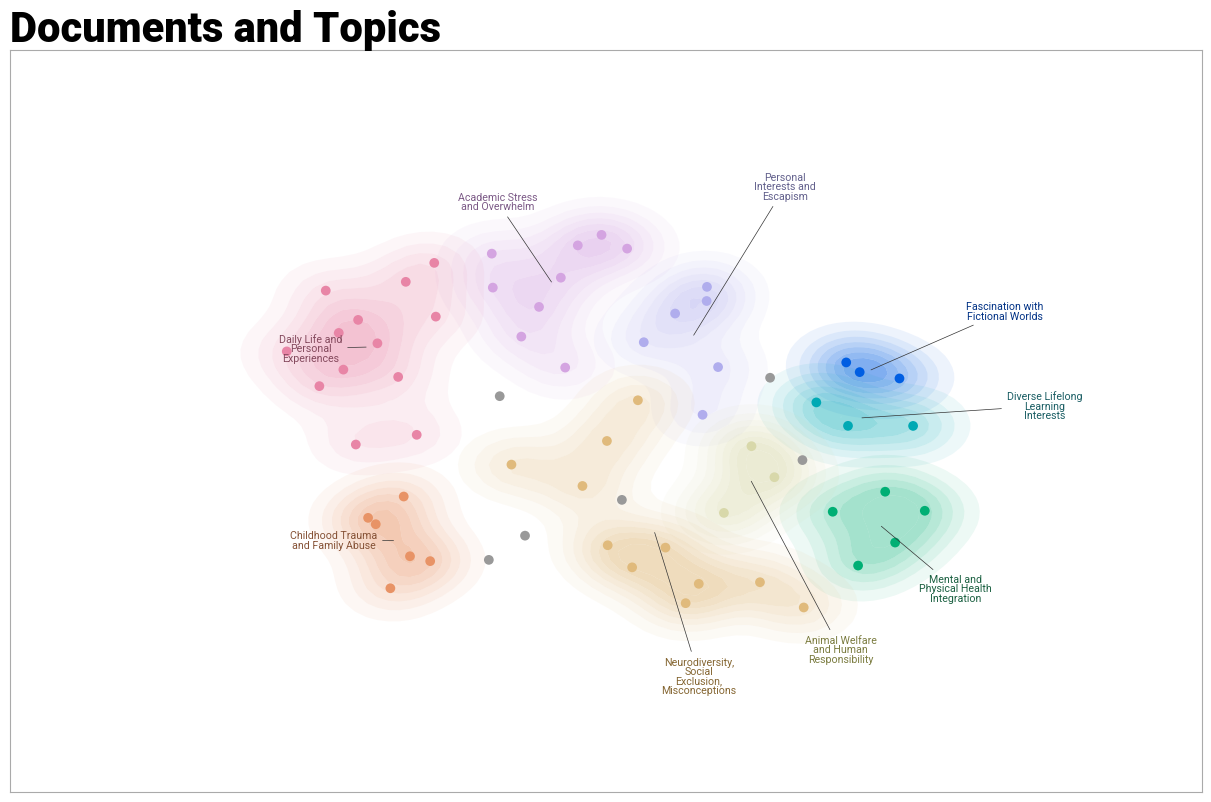

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: day, today, week, yet, why
Topic 1: adhd, people, there, life, where
Topic 2: to do, with you, time, work, hills
Topic 3: mother, memory, years, lots of, because
Topic 4: I started, muddy, interest, completely, child
Topic 5: health, interest, in this, accompanied, childish
Topic 6: world, so, I can explain, idea, explain
Topic 7: be, reasons, truly, trend, behavior
Topic 8: areas, all, special interest, special, interest
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Daily Life and Personal Experiences
DEBUG: Topic 1 -> Label: Neurodiversity, Social Exclusion, Misconceptions
DEBUG: Topic 2 -> Label: Academic Stress and Overwhelm
DEBUG: Topic 3 -> Label: Childhood Trauma and Family Abuse
DEBUG: Topic 4 -> Label: Personal Interests and Escapism
DEBUG: Topic 5 -> Label: Mental and Physical Health Integration
🔧 Applying translated_barchart specific optimizations...


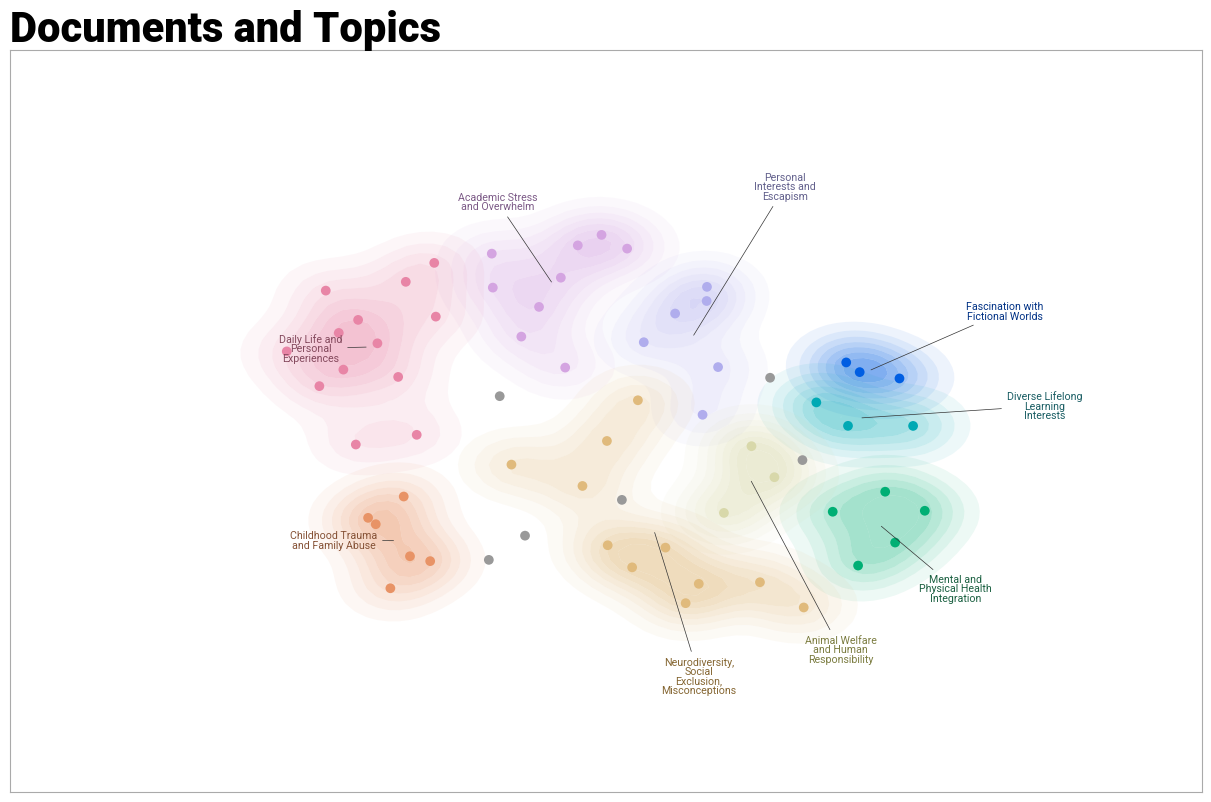

In [21]:
run_bertopic_viz(topic_model, df_group, output_folder, "Female_ADHD")

# Other Participants

In [22]:
folder = next(f for f in folders if f.startswith("Others_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Others")

Others_20250818_161900_minsize6
Running preliminary steps for folder: Others_20250818_161900_minsize6
Others


100%|██████████| 17/17 [00:00<00:00, 625.29it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Others as PNG: 20250824_193732_bertopic_hierarchy_others.png
📊 Saved bertopic_hierarchy_Others as HTML: 20250824_193732_bertopic_hierarchy_others.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Others as PNG: 20250824_193734_bertopic_topics_others.png
📊 Saved bertopic_topics_Others as HTML: 20250824_193734_bertopic_topics_others.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


.
├─dia_hoje_porque_fazer_trabalho
│    ├─memória_anos_lembro_mim_sempre
│    │    ├─■──algum_eventos_dia_perceber_situações ── Topic: 10
│    │    └─memória_anos_lembro_mim_sempre
│    │         ├─■──capaz_exame_nunca_mim_memória ── Topic: 17
│    │         └─memória_anos_lembro_altura_comigo
│    │              ├─■──altura_anos_dizer_comigo_memória ── Topic: 1
│    │              └─■──memória_lembro_avós_anos_morte ── Topic: 3
│    └─dia_hoje_fazer_trabalho_casa
│         ├─dia_hoje_fazer_casa_trabalho
│         │    ├─■──dia_bom_trabalho_campo_super ── Topic: 5
│         │    └─dia_casa_tarde_hoje_manhã
│         │         ├─■──fazer_porque_dia_tempo_coisas ── Topic: 2
│         │         └─■──tarde_pai_casa_hoje_acordei ── Topic: 0
│         └─■──hoje_mãe_pouco_diário_ainda ── Topic: 16
└─gosto_música_forma_vida_adoro
     ├─gosto_música_forma_vida_adoro
     │    ├─pessoas_medo_phda_medicação_vida
     │    │    ├─medo_medicação_phda_pessoas_vida
     │    │    │    ├─■──phda_medi

In [23]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

,Topic,Count,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,82,-1_escrever_algo_vezes_fazer,Outlier Topic,"[escrever, algo, vezes, fazer, tempo, menos, d...","[fiquei, senti, sinto confortável, muitas veze...",[Personal Productivity and Emotional Challenges],"[escrever, vezes, tempo, conseguir, sinto, vol...","[vezes, tempo, menos, dia, tipo, vez, dias, pe...",NaN
1,0,35,0_tarde_pai_casa_hoje,Daily Life and Family Relationships,"[tarde, pai, casa, hoje, acordei, ir, dia, man...","[hoje acordei, acordei, dormi, comecei, hoje, ...",[Daily Life and Family Relationships],"[tarde, acordei, ir, trabalhar, comecei, fiz, ...","[tarde, pai, casa, dia, manhã, almoço, noite, ...",NaN
2,1,32,1_altura_anos_dizer_comigo,Personal Growth and Relationships,"[altura, anos, dizer, comigo, memória, hoje, f...","[ansiedade, medo, mim, ia, comigo, momentos, s...",[Personal Growth and Relationships],"[memória, falar, cabeça, coisas, mim, queria, ...","[altura, anos, comigo, memória, cabeça, coisas...",NaN
3,2,24,2_fazer_porque_dia_tempo,Daily Stress and Emotional Challenges,"[fazer, porque, dia, tempo, coisas, trabalho, ...","[stress, acordei, stressada, trabalhei, cansaç...",[Daily Stress and Emotional Challenges],"[fazer, tempo, coisas, senti, nervosa, quero, ...","[dia, tempo, coisas, trabalho, manhã, semana, ...",NaN
4,3,20,3_memória_lembro_avós_anos,Childhood Memories and Loss,"[memória, lembro, avós, anos, morte, sempre, a...","[memória vem, saudades, memória, conheci, emoç...",[Childhood Memories and Loss],"[memória, avós, anos, amor, conheci, família, ...","[memória, avós, anos, morte, amor, pessoa, our...",NaN
5,4,19,4_ler_forma_livros_gosto,Reading Fiction and Personal Growth,"[ler, forma, livros, gosto, histórias, saga, i...","[livros, livro, ler, relaxar, lido, histórias,...",[Reading Fiction and Personal Growth],"[livros, histórias, saga, lido, historia, semp...","[forma, livros, gosto, histórias, saga, intere...",NaN
6,5,18,5_dia_bom_trabalho_campo,Personal Growth and Achievement,"[dia, bom, trabalho, campo, super, ja, feliz, ...","[fazer, mim, fazemos, tarefas, envolve, fiz, m...",[Personal Growth and Achievement],"[feliz, nervoso, criativo, hoje, mental, conse...","[dia, bom, trabalho, campo, super, feliz, nerv...",NaN
7,6,18,6_sentir_dá_adoro_permite,Relaxation Through Hobbies and Nature,"[sentir, dá, adoro, permite, gosto, dia dia, a...","[permite relaxar, gosto fazer, adoro fazer, ap...",[Relaxation Through Hobbies and Nature],"[sentir, acalma, liberdade, atividades, sol, p...","[dia, liberdade, atividades, sol, pensamentos,...",NaN
8,7,18,7_desporto_personagens_história_animais,Personal Interests in Hobbies,"[desporto, personagens, história, animais, ver...","[gosto jogar, envolve, desafiantes, especial, ...",[Personal Interests in Hobbies],"[desporto, personagens, história, ver, anime, ...","[desporto, personagens, história, animais, per...",NaN
9,8,17,8_música_ouvir_músicas_ouvir música,Personal Relationship with Music,"[música, ouvir, músicas, ouvir música, homem, ...","[ouvir música, música, músicas, tocar, ouvir, ...",[Personal Relationship with Music],"[músicas, ouvir música, teatro, gostos, fazer,...","[música, músicas, teatro, homem, gostos, inter...",NaN


In [24]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 300 documents across 18 topics
Silhouette Score: 0.0400
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.5694
Individual Topic Coherences:
  Topic 0: -1.2733
  Topic 1: -1.3271
  Topic 2: -1.6941
  Topic 3: -1.8074
  Topic 4: -1.5899
  Topic 5: -1.9938
  Topic 6: -1.5979
  Topic 7: -1.3006
  Topic 8: -1.0977
  Topic 9: -1.7031
  Topic 10: -1.8471
  Topic 11: -1.2390
  Topic 12: -1.9788
  Topic 13: -1.9576
  Topic 14: -1.2989
  Topic 15: -1.1958
  Topic 16: -1.7846
  Topic 17: -1.5630
Coherence results saved to ../../outputs/bertopic_results/Others_20250818_161900_minsize6/


Number of texts: 382
Number of topics: 382


,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",13,13_gosto_cozinhar_adoro_pessoas,Personal Tastes and Joyful Experiences,"[gosto, cozinhar, adoro, pessoas, visitar, fav...","[porque gosto, liberdade criativa, gosto ver, ...",[Personal Tastes and Joyful Experiences],"[gosto, cozinhar, favoritas, experiências, uti...","[gosto, pessoas, receitas, experiências, favor...",NaN,gosto - cozinhar - adoro - pessoas - visitar -...,False
1,Gosto de ver séries porque relatam relações sa...,4,4_ler_forma_livros_gosto,Reading Fiction and Personal Growth,"[ler, forma, livros, gosto, histórias, saga, i...","[livros, livro, ler, relaxar, lido, histórias,...",[Reading Fiction and Personal Growth],"[livros, histórias, saga, lido, historia, semp...","[forma, livros, gosto, histórias, saga, intere...",NaN,ler - forma - livros - gosto - histórias - sag...,False
2,Campos de ferias. Temos que criar o campo todo...,5,5_dia_bom_trabalho_campo,Personal Growth and Achievement,"[dia, bom, trabalho, campo, super, ja, feliz, ...","[fazer, mim, fazemos, tarefas, envolve, fiz, m...",[Personal Growth and Achievement],"[feliz, nervoso, criativo, hoje, mental, conse...","[dia, bom, trabalho, campo, super, feliz, nerv...",NaN,dia - bom - trabalho - campo - super - ja - fe...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",7,7_desporto_personagens_história_animais,Personal Interests in Hobbies,"[desporto, personagens, história, animais, ver...","[gosto jogar, envolve, desafiantes, especial, ...",[Personal Interests in Hobbies],"[desporto, personagens, história, ver, anime, ...","[desporto, personagens, história, animais, per...",NaN,desporto - personagens - história - animais - ...,False
4,Historia da arte \nÉ só tão interessante. Para...,11,11_interessante_física_política_corpo,Interdisciplinary Curiosity and Understanding,"[interessante, física, política, corpo, valore...","[várias técnicas, políticas, assuntos, temas, ...",[Interdisciplinary Curiosity and Understanding],"[interessante, física, valores, entender, polí...","[interessante, física, política, corpo, valore...",NaN,interessante - física - política - corpo - val...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
377,—,-1,-1_escrever_algo_vezes_fazer,Outlier Topic,"[escrever, algo, vezes, fazer, tempo, menos, d...","[fiquei, senti, sinto confortável, muitas veze...",[Personal Productivity and Emotional Challenges],"[escrever, vezes, tempo, conseguir, sinto, vol...","[vezes, tempo, menos, dia, tipo, vez, dias, pe...",NaN,escrever - algo - vezes - fazer - tempo - meno...,False
378,As vezes aborrece-me ter de escrever/responder...,-1,-1_escrever_algo_vezes_fazer,Outlier Topic,"[escrever, algo, vezes, fazer, tempo, menos, d...","[fiquei, senti, sinto confortável, muitas veze...",[Personal Productivity and Emotional Challenges],"[escrever, vezes, tempo, conseguir, sinto, vol...","[vezes, tempo, menos, dia, tipo, vez, dias, pe...",NaN,escrever - algo - vezes - fazer - tempo - meno...,False
379,Maiores dificuldades que sempre senti.. Concen...,12,12_pessoas_medo_onde_vida,Personal Uncertainty and Social Concerns,"[pessoas, medo, onde, vida, momento, atenção, ...","[vezes medo, medo, dificuldades, saúde mental,...",[Personal Uncertainty and Social Concerns],"[medo, atenção, cabeça, eleições, país, pés, l...","[pessoas, medo, vida, momento, atenção, cabeça...",NaN,pessoas - medo - onde - vida - momento - atenç...,False
380,"De momento, na minha cabeça, só rumino sobre o...",17,17_capaz_exame_nunca_mim,Academic Self-Doubt and Overcoming,"[capaz, exame, nunca, mim, memória, faculdade,...","[stressar, tentar acabar, aulas, depressão, pe...",[Academic Self-Doubt and Overcoming],"[nunca, memória, faculdade, professora, vezes,...","[capaz, exame, memória, faculdade, professora,...",NaN,capaz - exame - nunca - mim - memória - faculd...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Others as PNG: 20250824_193736_bertopic_heatmap_others.png
📊 Saved bertopic_heatmap_Others as HTML: 20250824_193736_bertopic_heatmap_others.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


4it [00:00, 100.35it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Others as PNG: 20250824_193737_bertopic_topics_per_class_others.png
📊 Saved bertopic_topics_per_class_Others as HTML: 20250824_193737_bertopic_topics_per_class_others.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Others as PNG: 20250824_193741_bertopic_document_datamap_others.png
📊 Saved bertopic_document_datamap_Others as HTML: 20250824_193741_bertopic_document_datamap_others.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Others'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Others_20250818_161900_minsize6
------------------------------------------------------------


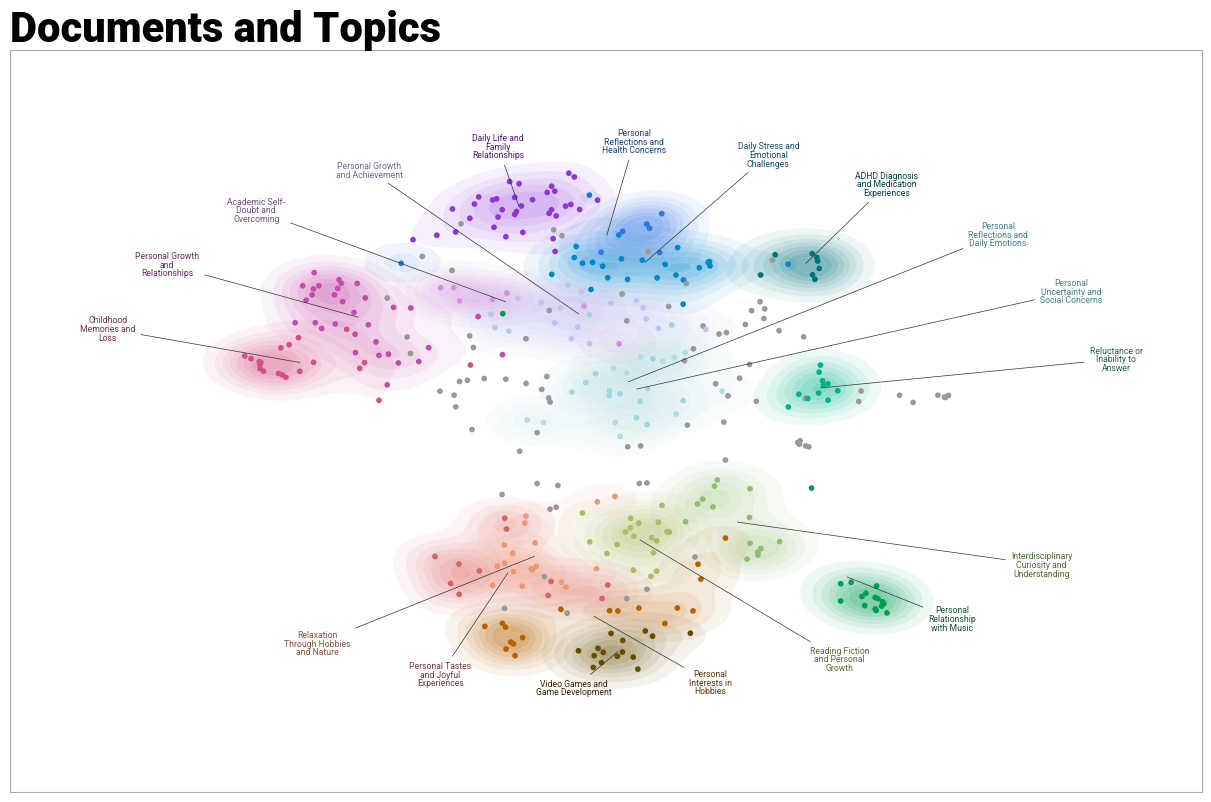

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: afternoon, father, home, today, I woke up
Topic 1: height, years, to say, with me, memory
Topic 2: to do, why, day, time, things
Topic 3: memory, I remember, grandparents, years, death
Topic 4: to read, shape, books, I like, stories
Topic 5: day, good, work, field, super
Topic 6: to feel, from the, I adore, allow, I like
Topic 7: sport, characters, history, animals, see
Topic 8: music, to hear, songs, listen, man
Topic 9: games, to play, game, I like, always
Topic 10: some, events, day, to perceive, situations
Topic 11: interesting, physical, policy, body, values
Topic 12: people, fear, where, life, moment
Topic 13: I like, to cook, I adore, people, visit
Topic 14: to respond, none, I prefer, occur, question
Topic 15: adhd, medication, psychiatrist, to start, state
Topic 16: today, mother, little, daily, yet
Topic 17: able, exam, never, me, memory
DEBUG: Available topics for plotting: [0, 1, 2, 3,

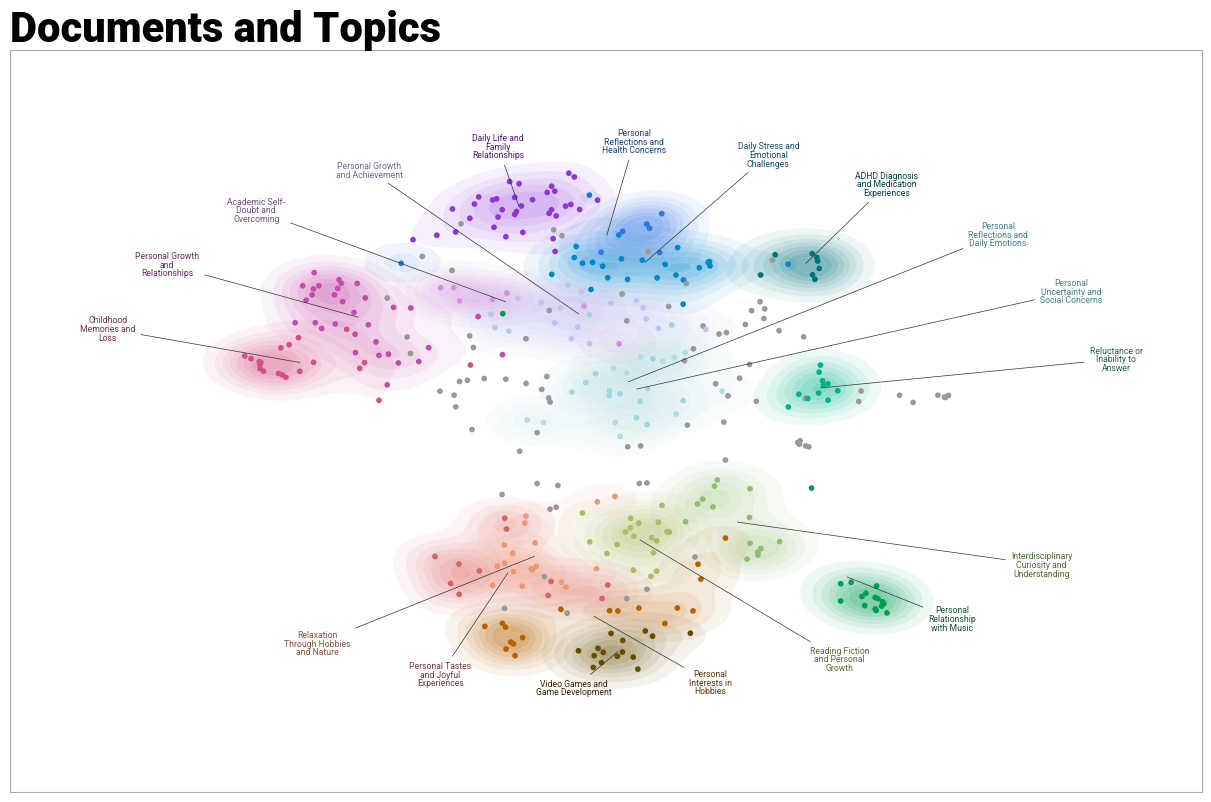

In [25]:
run_bertopic_viz(topic_model, df_group, output_folder, "Others")

# Female non-ADHD

In [26]:
folder = next(f for f in folders if f.startswith("Female_noADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Female_noADHD")

Female_noADHD_20250818_135710_2
Running preliminary steps for folder: Female_noADHD_20250818_135710_2
Female_noADHD


100%|██████████| 11/11 [00:00<00:00, 598.74it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Female_noADHD as PNG: 20250824_193857_bertopic_hierarchy_female_noadhd.png
📊 Saved bertopic_hierarchy_Female_noADHD as HTML: 20250824_193857_bertopic_hierarchy_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250818_135710_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Female_noADHD as PNG: 20250824_193858_bertopic_topics_female_noadhd.png
📊 Saved bertopic_topics_Female_noADHD as HTML: 20250824_193858_bertopic_topics_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250818_135710_2
------------------------------------------------------------


.
├─■──responder_prefiro_biblioteca_nenhuma_escrita ── Topic: 5
└─dia_porque_fazer_hoje_sinto
     ├─memória_lembro_anos_emoções_sempre
     │    ├─memória_lembro_anos_sempre_morte
     │    │    ├─■──mulher_lembro_mãe_memória_escolher ── Topic: 10
     │    │    └─■──memória_anos_morte_ouro_infância ── Topic: 4
     │    └─■──memórias_dia_emoções_bom_felicidade ── Topic: 3
     └─porque_dia_fazer_hoje_gosto
          ├─fazer_porque_dia_hoje_ainda
          │    ├─porque_dia_fazer_hoje_ainda
          │    │    ├─dia_hoje_fazer_trabalho_porque
          │    │    │    ├─■──hoje_melhor_começar_sei bem_ainda ── Topic: 11
          │    │    │    └─■──dia_hoje_fazer_trabalho_casa ── Topic: 0
          │    │    └─gosto_porque_forma_sinto_ler
          │    │         ├─gosto_forma_porque_ler_algo
          │    │         │    ├─■──gosto_ler_forma_porque_interesse ── Topic: 1
          │    │         │    └─■──dizer_idade_lembro_mãe_dentista ── Topic: 7
          │    │         └─■──mim_exa

In [27]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

,Topic,Count,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,24,-1_gosto_queria_fazer_falar,Outlier Topic,"[gosto, queria, fazer, falar, ver, coisas, dia...","[comigo, ia, altura, aulas, aula, durante, que...",[Personal Struggles and Self-Discovery],"[queria, falar, coisas, nunca, aulas, consegui...","[gosto, coisas, dia, animais, aula, aulas, alt...",NaN
1,0,59,0_dia_hoje_fazer_trabalho,Daily Experiences and Reflections,"[dia, hoje, fazer, trabalho, casa, porque, pai...","[acordei, comecei, fiquei, passei, acordar, fi...",[Daily Experiences and Reflections],"[hoje, pai, acordei, tarde, quero, trabalhar, ...","[dia, trabalho, casa, pai, manhã, tempo, tarde...",NaN
2,1,40,1_gosto_ler_forma_porque,Passion for Stories and Media,"[gosto, ler, forma, porque, interesse, adoro, ...","[livros, ler, histórias, especialmente, lido, ...",[Passion for Stories and Media],"[gosto, livros, músicas, vida, coisas, especia...","[forma, interesse, livros, músicas, história, ...",NaN
3,2,14,2_pessoas_cabeça_atenção_medo,"Gender, Politics, and Technology Concerns","[pessoas, cabeça, atenção, medo, escrever, fem...","[mexer, mim sinto, dificuldades, políticas, cr...","[Gender, Politics, and Technology Concerns]","[cabeça, medo, feminino, eleições, chatgpt, co...","[pessoas, cabeça, atenção, medo, mulheres, fem...",NaN
4,3,12,3_memórias_dia_emoções_bom,Personal Memories and Emotions,"[memórias, dia, emoções, bom, felicidade, mau,...","[memórias, esqueço, senti, emoções, chorei, se...",[Personal Memories and Emotions],"[memórias, emoções, felicidade, momentos, sent...","[memórias, dia, emoções, bom, felicidade, mau,...",NaN
5,4,12,4_memória_anos_morte_ouro,"Grandparents, Loss, and Childhood Memories","[memória, anos, morte, ouro, infância, lembro,...","[memória vem, cresci, memória, conheci, durant...","[Grandparents, Loss, and Childhood Memories]","[memória, morte, amor, nunca, dor, várias veze...","[memória, anos, morte, ouro, infância, amor, c...",NaN
6,5,11,5_responder_prefiro_biblioteca_nenhuma,Declining or Unsure Answers,"[responder, prefiro, biblioteca, nenhuma, escr...","[prefiro, responder, escrita, nenhuma, pergunt...",[Declining or Unsure Answers],"[responder, prefiro, biblioteca, nenhuma, escr...","[biblioteca, escrita, pergunta, momento, pesso...",NaN
7,6,9,6_mim_exame_inglês_tudo,Personal Growth Through Adversity,"[mim, exame, inglês, tudo, caminho, fazer exam...","[dediquei, emocionalmente, fiquei pensar, sair...",[Personal Growth Through Adversity],"[mim, inglês, fazer exame, tirar, gostava, mun...","[exame, inglês, caminho, capaz, nova, mesma, m...",NaN
8,7,9,7_dizer_idade_lembro_mãe,Personal Memories and Self-Reflection,"[dizer, idade, lembro, mãe, dentista, algo, si...","[memória, conheci, ansiedade, mim, sinto, altu...",[Personal Memories and Self-Reflection],"[idade, mãe, dentista, sinto, memória, cabeça,...","[idade, mãe, dentista, verdade, memória, notas...",NaN
9,8,8,8_música_ouvir_enquanto_tocar,Music as Emotional Escape,"[música, ouvir, enquanto, tocar, tanto, aprend...","[música, musical, tocar, ouvir, piano, faço, r...",[Music as Emotional Escape],"[música, ouvir, tocar, aprender, vida, faço, c...","[música, tanto, vida, coisas, pensamentos, vez...",NaN


In [28]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 196 documents across 12 topics
Silhouette Score: 0.0294
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -1.3479
Individual Topic Coherences:
  Topic 0: -1.3137
  Topic 1: -1.6352
  Topic 2: -1.8302
  Topic 3: -1.5130
  Topic 4: -1.3873
  Topic 5: -0.9940
  Topic 6: -1.3278
  Topic 7: -1.3902
  Topic 8: -0.9034
  Topic 9: -1.4059
  Topic 10: -1.0626
  Topic 11: -1.4113
Coherence results saved to ../../outputs/bertopic_results/Female_noADHD_20250818_135710_2/


Number of texts: 220
Number of topics: 220


,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Adoro cozinhar, porque sinto que é a forma ide...",1,1_gosto_ler_forma_porque,Passion for Stories and Media,"[gosto, ler, forma, porque, interesse, adoro, ...","[livros, ler, histórias, especialmente, lido, ...",[Passion for Stories and Media],"[gosto, livros, músicas, vida, coisas, especia...","[forma, interesse, livros, músicas, história, ...",NaN,gosto - ler - forma - porque - interesse - ado...,False
1,Gosto de ver séries porque relatam relações sa...,1,1_gosto_ler_forma_porque,Passion for Stories and Media,"[gosto, ler, forma, porque, interesse, adoro, ...","[livros, ler, histórias, especialmente, lido, ...",[Passion for Stories and Media],"[gosto, livros, músicas, vida, coisas, especia...","[forma, interesse, livros, músicas, história, ...",NaN,gosto - ler - forma - porque - interesse - ado...,False
2,Campos de ferias. Temos que criar o campo todo...,-1,-1_gosto_queria_fazer_falar,Outlier Topic,"[gosto, queria, fazer, falar, ver, coisas, dia...","[comigo, ia, altura, aulas, aula, durante, que...",[Personal Struggles and Self-Discovery],"[queria, falar, coisas, nunca, aulas, consegui...","[gosto, coisas, dia, animais, aula, aulas, alt...",NaN,gosto - queria - fazer - falar - ver - coisas ...,False
3,"Taylor Swift, amo o seu liricismo e a maneira ...",1,1_gosto_ler_forma_porque,Passion for Stories and Media,"[gosto, ler, forma, porque, interesse, adoro, ...","[livros, ler, histórias, especialmente, lido, ...",[Passion for Stories and Media],"[gosto, livros, músicas, vida, coisas, especia...","[forma, interesse, livros, músicas, história, ...",NaN,gosto - ler - forma - porque - interesse - ado...,False
4,Historia da arte \nÉ só tão interessante. Para...,-1,-1_gosto_queria_fazer_falar,Outlier Topic,"[gosto, queria, fazer, falar, ver, coisas, dia...","[comigo, ia, altura, aulas, aula, durante, que...",[Personal Struggles and Self-Discovery],"[queria, falar, coisas, nunca, aulas, consegui...","[gosto, coisas, dia, animais, aula, aulas, alt...",NaN,gosto - queria - fazer - falar - ver - coisas ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
215,A noção de que procuro ser sempre uma boa pess...,0,0_dia_hoje_fazer_trabalho,Daily Experiences and Reflections,"[dia, hoje, fazer, trabalho, casa, porque, pai...","[acordei, comecei, fiquei, passei, acordar, fi...",[Daily Experiences and Reflections],"[hoje, pai, acordei, tarde, quero, trabalhar, ...","[dia, trabalho, casa, pai, manhã, tempo, tarde...",NaN,dia - hoje - fazer - trabalho - casa - porque ...,False
216,—,5,5_responder_prefiro_biblioteca_nenhuma,Declining or Unsure Answers,"[responder, prefiro, biblioteca, nenhuma, escr...","[prefiro, responder, escrita, nenhuma, pergunt...",[Declining or Unsure Answers],"[responder, prefiro, biblioteca, nenhuma, escr...","[biblioteca, escrita, pergunta, momento, pesso...",NaN,responder - prefiro - biblioteca - nenhuma - e...,False
217,As vezes aborrece-me ter de escrever/responder...,0,0_dia_hoje_fazer_trabalho,Daily Experiences and Reflections,"[dia, hoje, fazer, trabalho, casa, porque, pai...","[acordei, comecei, fiquei, passei, acordar, fi...",[Daily Experiences and Reflections],"[hoje, pai, acordei, tarde, quero, trabalhar, ...","[dia, trabalho, casa, pai, manhã, tempo, tarde...",NaN,dia - hoje - fazer - trabalho - casa - porque ...,False
218,Maiores dificuldades que sempre senti.. Concen...,2,2_pessoas_cabeça_atenção_medo,"Gender, Politics, and Technology Concerns","[pessoas, cabeça, atenção, medo, escrever, fem...","[mexer, mim sinto, dificuldades, políticas, cr...","[Gender, Politics, and Technology Concerns]","[cabeça, medo, feminino, eleições, chatgpt, co...","[pessoas, cabeça, atenção, medo, mulheres, fem...",NaN,pessoas - cabeça - atenção - medo - escrever -...,False


🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Female_noADHD as PNG: 20250824_193900_bertopic_heatmap_female_noadhd.png
📊 Saved bertopic_heatmap_Female_noADHD as HTML: 20250824_193900_bertopic_heatmap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250818_135710_2
------------------------------------------------------------


4it [00:00, 130.42it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Female_noADHD as PNG: 20250824_193902_bertopic_topics_per_class_female_noadhd.png
📊 Saved bertopic_topics_per_class_Female_noADHD as HTML: 20250824_193902_bertopic_topics_per_class_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250818_135710_2
------------------------------------------------------------


🖼️  Saved bertopic_document_datamap_Female_noADHD as PNG: 20250824_193905_bertopic_document_datamap_female_noadhd.png
📊 Saved bertopic_document_datamap_Female_noADHD as HTML: 20250824_193905_bertopic_document_datamap_female_noadhd.html
✅ Total saved: 2 file(s) for 'bertopic_document_datamap_Female_noADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Female_noADHD_20250818_135710_2
------------------------------------------------------------


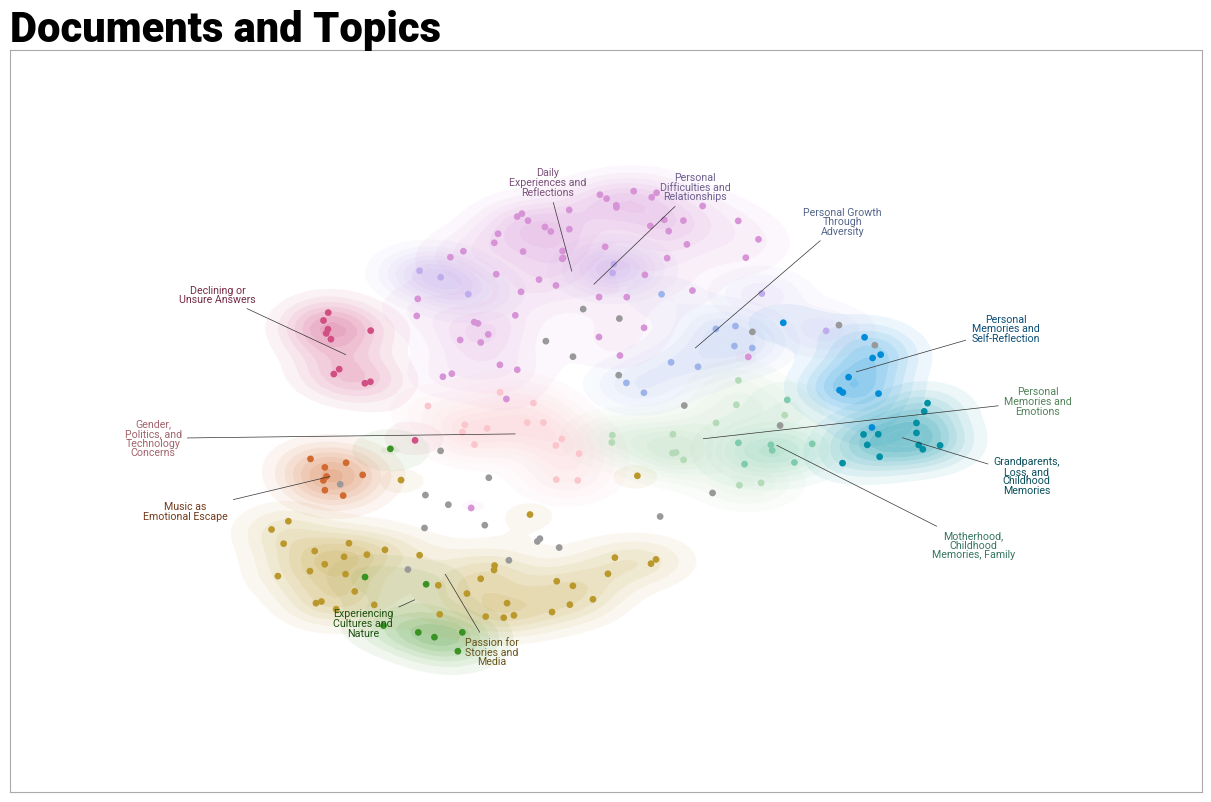

Translating topic words to English...

Translated Topics (Portuguese → English):
Topic 0: day, today, to do, work, home
Topic 1: I like, to read, shape, why, interest
Topic 2: people, head, attention, fear, to write
Topic 3: memories, day, emotions, good, happiness
Topic 4: memory, years, death, gold, infancy
Topic 5: to respond, I prefer, library, none, writing
Topic 6: me, exam, English, all, path
Topic 7: to say, age, I remember, mother, dentist
Topic 8: music, to hear, while, touch, both
Topic 9: travel, new, to feel, silence, world
Topic 10: woman, I remember, mother, memory, to choose
Topic 11: today, better, to start, I know well, yet
DEBUG: Available topics for plotting: [0, 1, 2, 3, 4, 5]
DEBUG: Topic 0 -> Label: Daily Experiences and Reflections
DEBUG: Topic 1 -> Label: Passion for Stories and Media
DEBUG: Topic 2 -> Label: Gender, Politics, and Technology Concerns
DEBUG: Topic 3 -> Label: Personal Memories and Emotions
DEBUG: Topic 4 -> Label: Grandparents, Loss, and Childho

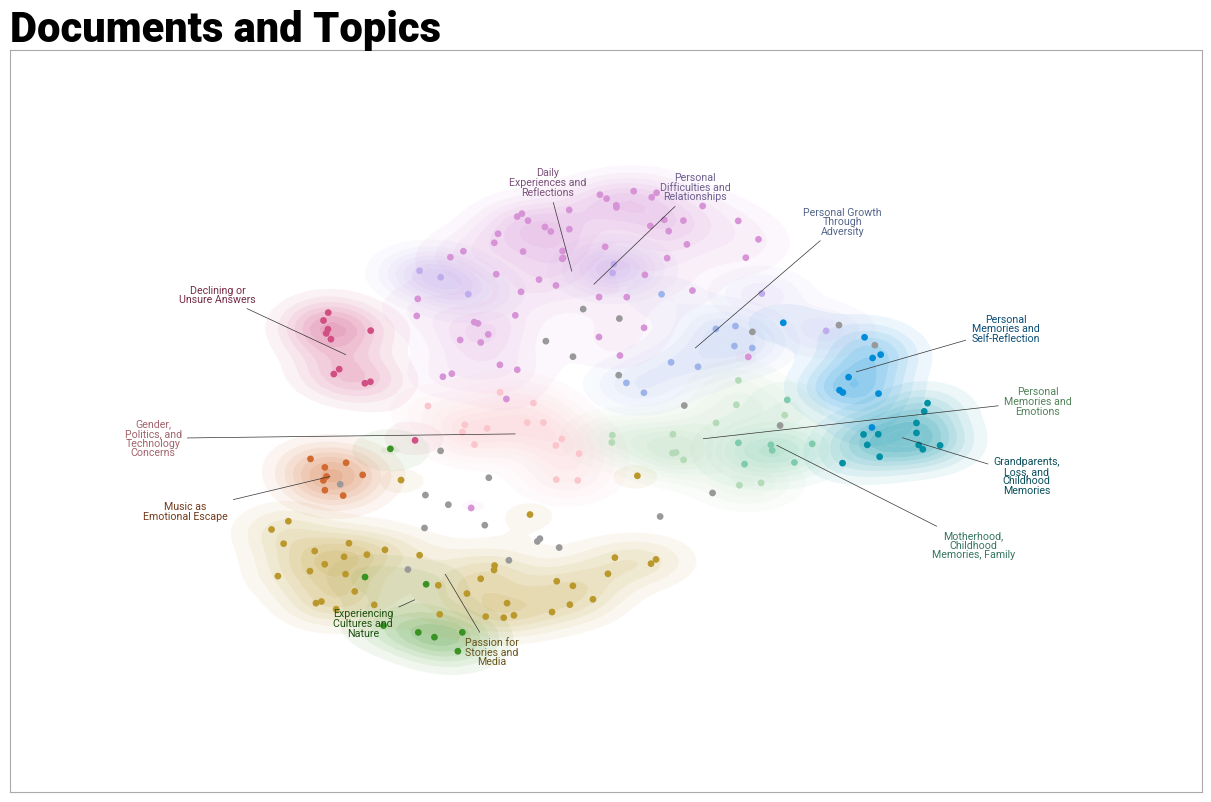

In [29]:
run_bertopic_viz(topic_model, df_group, output_folder, "Female_noADHD")

# Male ADHD

In [30]:
folder = next(f for f in folders if f.startswith("Male_ADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male_ADHD")

Male_ADHD_20250818_135710_2
Running preliminary steps for folder: Male_ADHD_20250818_135710_2
Male_ADHD


100%|██████████| 5/5 [00:00<00:00, 580.21it/s]


🔧 Applying hierarchy specific optimizations...
🖼️  Saved bertopic_hierarchy_Male_ADHD as PNG: 20250824_194005_bertopic_hierarchy_male_adhd.png
📊 Saved bertopic_hierarchy_Male_ADHD as HTML: 20250824_194005_bertopic_hierarchy_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_hierarchy_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


🔧 Applying topics specific optimizations...
🖼️  Saved bertopic_topics_Male_ADHD as PNG: 20250824_194007_bertopic_topics_male_adhd.png
📊 Saved bertopic_topics_Male_ADHD as HTML: 20250824_194007_bertopic_topics_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


.
├─gosto_jogo_tudo_algo_vez
│    ├─■──gosto_jogo_algo_sempre_jogar ── Topic: 0
│    └─■──apenas_tudo_todo_coisas_saber ── Topic: 1
└─dia_semana_phda_porque_nada
     ├─semana_phda_pessoas_trabalho_hoje
     │    ├─trabalho_semana_hoje_tarde_porque
     │    │    ├─■──pessoas_empreendedorismo_porque_super_contudo ── Topic: 5
     │    │    └─■──hoje_semana_tarde_casa_nada ── Topic: 3
     │    └─■──phda_medicação_nível_sinto_poder ── Topic: 2
     └─■──mim_dia_saber_nada_ainda ── Topic: 4



In [31]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

,Topic,Count,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,4,-1_tentar_ainda_qualquer_dia,Outlier Topic,"[tentar, ainda, qualquer, dia, próximas, começ...","[fazer, falta, muitas, tempo, embora, tido, ph...",[Human Experience and Daily Struggles],"[tentar, ainda, próximas, possam, dias, falta,...","[dia, dias, próximas, humana, tempo, falta, ca...",NaN
1,0,6,0_gosto_jogo_algo_sempre,Enjoyment of Structured Gaming Experiences,"[gosto, jogo, algo, sempre, jogar, fez, vez, v...","[memórias, buscar, fazer, stressar, partir, jo...",[Enjoyment of Structured Gaming Experiences],"[gosto, jogar, vezes, buscar, stressar, qualqu...","[gosto, jogo, vez, vezes, tipo, procura, memór...",NaN
2,1,4,1_apenas_tudo_todo_coisas,Interdisciplinary Curiosity and Human Understa...,"[apenas, tudo, todo, coisas, saber, estudo, go...","[fazer, várias, saber, coisas, ideias, tipo, v...",[Interdisciplinary Curiosity and Human Underst...,"[coisas, saber, estudo, várias, perder, ideias...","[coisas, estudo, humana, ideias, cada, pessoa,...",NaN
3,2,4,2_phda_medicação_nível_sinto,"ADHD, Depression, and Medication Challenges","[phda, medicação, nível, sinto, poder, muitas,...","[phda, sinto, sair, muitas, medicação, bastant...","[ADHD, Depression, and Medication Challenges]","[phda, medicação, poder, muitas, vida, tomar, ...","[nível, medicação, poder, super, tipo, pessoas...",NaN
4,3,4,3_hoje_semana_tarde_casa,Daily Routines and Productivity Challenges,"[hoje, semana, tarde, casa, nada, pois, trabal...","[hoje, tempo, dia, ansioso, durante, fazer, ro...",[Daily Routines and Productivity Challenges],"[sair, dia, universidade, adhd, 2025, ansioso,...","[semana, tarde, casa, trabalho, dia, rotinas, ...",NaN
5,4,4,4_mim_dia_saber_nada,Difficult Personal Memories and Identity,"[mim, dia, saber, nada, ainda, sinto, tido, im...","[memórias, sinto, mim, tido, falta, difícil, i...",[Difficult Personal Memories and Identity],"[ainda, sinto, tido, importante, amigo, memóri...","[dia, importante, bocado, assunto, difícil, me...",NaN
6,5,3,5_pessoas_empreendedorismo_porque_super,Academic Stress and Personal Growth,"[pessoas, empreendedorismo, porque, super, con...","[stressar, ansioso, mim, vezes, número, rotina...",[Academic Stress and Personal Growth],"[empreendedorismo, sempre, vida, correu, coleg...","[pessoas, empreendedorismo, cabeça, super, vez...",NaN


In [32]:
run_bertopic_evals(topic_model, df_group, output_folder)

Silhouette score calculated on 25 documents across 6 topics
Silhouette Score: 0.0525
Calculating topic coherence using UMass metric...
Vectorizer available!
Average Topic Coherence (UMass): -0.5774
Individual Topic Coherences:
  Topic 0: -0.5110
  Topic 1: -0.8060
  Topic 2: -0.3526
  Topic 3: -0.4211
  Topic 4: -0.7959
  Topic 5: -0.5775
Coherence results saved to ../../outputs/bertopic_results/Male_ADHD_20250818_135710_2/


In [33]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male_ADHD")

Number of texts: 29
Number of topics: 29


,Document,Topic,Name,CustomName,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs,Top_n_words,Representative_document
0,"Não estudo no sentido literal, mas interesso-m...",1,1_apenas_tudo_todo_coisas,Interdisciplinary Curiosity and Human Understa...,"[apenas, tudo, todo, coisas, saber, estudo, go...","[fazer, várias, saber, coisas, ideias, tipo, v...",[Interdisciplinary Curiosity and Human Underst...,"[coisas, saber, estudo, várias, perder, ideias...","[coisas, estudo, humana, ideias, cada, pessoa,...",NaN,apenas - tudo - todo - coisas - saber - estudo...,False
1,Linux!,0,0_gosto_jogo_algo_sempre,Enjoyment of Structured Gaming Experiences,"[gosto, jogo, algo, sempre, jogar, fez, vez, v...","[memórias, buscar, fazer, stressar, partir, jo...",[Enjoyment of Structured Gaming Experiences],"[gosto, jogar, vezes, buscar, stressar, qualqu...","[gosto, jogo, vez, vezes, tipo, procura, memór...",NaN,gosto - jogo - algo - sempre - jogar - fez - v...,False
2,Gosto muito de arrumação gosto de ter tudo arr...,0,0_gosto_jogo_algo_sempre,Enjoyment of Structured Gaming Experiences,"[gosto, jogo, algo, sempre, jogar, fez, vez, v...","[memórias, buscar, fazer, stressar, partir, jo...",[Enjoyment of Structured Gaming Experiences],"[gosto, jogar, vezes, buscar, stressar, qualqu...","[gosto, jogo, vez, vezes, tipo, procura, memór...",NaN,gosto - jogo - algo - sempre - jogar - fez - v...,False
3,"Gosto imenso de montanhas russas, às vezes gos...",0,0_gosto_jogo_algo_sempre,Enjoyment of Structured Gaming Experiences,"[gosto, jogo, algo, sempre, jogar, fez, vez, v...","[memórias, buscar, fazer, stressar, partir, jo...",[Enjoyment of Structured Gaming Experiences],"[gosto, jogar, vezes, buscar, stressar, qualqu...","[gosto, jogo, vez, vezes, tipo, procura, memór...",NaN,gosto - jogo - algo - sempre - jogar - fez - v...,False
4,"Eu gosto de jogos repetitivos, pois são privis...",0,0_gosto_jogo_algo_sempre,Enjoyment of Structured Gaming Experiences,"[gosto, jogo, algo, sempre, jogar, fez, vez, v...","[memórias, buscar, fazer, stressar, partir, jo...",[Enjoyment of Structured Gaming Experiences],"[gosto, jogar, vezes, buscar, stressar, qualqu...","[gosto, jogo, vez, vezes, tipo, procura, memór...",NaN,gosto - jogo - algo - sempre - jogar - fez - v...,False
5,Um dos meu intereses especiais é ark que é um ...,0,0_gosto_jogo_algo_sempre,Enjoyment of Structured Gaming Experiences,"[gosto, jogo, algo, sempre, jogar, fez, vez, v...","[memórias, buscar, fazer, stressar, partir, jo...",[Enjoyment of Structured Gaming Experiences],"[gosto, jogar, vezes, buscar, stressar, qualqu...","[gosto, jogo, vez, vezes, tipo, procura, memór...",NaN,gosto - jogo - algo - sempre - jogar - fez - v...,False
6,Videografia/cinematografia é uma das áreas da ...,1,1_apenas_tudo_todo_coisas,Interdisciplinary Curiosity and Human Understa...,"[apenas, tudo, todo, coisas, saber, estudo, go...","[fazer, várias, saber, coisas, ideias, tipo, v...",[Interdisciplinary Curiosity and Human Underst...,"[coisas, saber, estudo, várias, perder, ideias...","[coisas, estudo, humana, ideias, cada, pessoa,...",NaN,apenas - tudo - todo - coisas - saber - estudo...,False
7,"Ultimamente, ando particularmente interessado ...",1,1_apenas_tudo_todo_coisas,Interdisciplinary Curiosity and Human Understa...,"[apenas, tudo, todo, coisas, saber, estudo, go...","[fazer, várias, saber, coisas, ideias, tipo, v...",[Interdisciplinary Curiosity and Human Underst...,"[coisas, saber, estudo, várias, perder, ideias...","[coisas, estudo, humana, ideias, cada, pessoa,...",NaN,apenas - tudo - todo - coisas - saber - estudo...,False
8,"Adoro ""tudo"" no geral, saber como tudo funcion...",1,1_apenas_tudo_todo_coisas,Interdisciplinary Curiosity and Human Understa...,"[apenas, tudo, todo, coisas, saber, estudo, go...","[fazer, várias, saber, coisas, ideias, tipo, v...",[Interdisciplinary Curiosity and Human Underst...,"[coisas, saber, estudo, várias, perder, ideias...","[coisas, estudo, humana, ideias, cada, pessoa,...

🔧 Applying heatmap specific optimizations...
🖼️  Saved bertopic_heatmap_Male_ADHD as PNG: 20250824_194008_bertopic_heatmap_male_adhd.png
📊 Saved bertopic_heatmap_Male_ADHD as HTML: 20250824_194008_bertopic_heatmap_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_heatmap_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


4it [00:00, 218.24it/s]

🔧 Applying topics_per_class specific optimizations...


🖼️  Saved bertopic_topics_per_class_Male_ADHD as PNG: 20250824_194010_bertopic_topics_per_class_male_adhd.png
📊 Saved bertopic_topics_per_class_Male_ADHD as HTML: 20250824_194010_bertopic_topics_per_class_male_adhd.html
✅ Total saved: 2 file(s) for 'bertopic_topics_per_class_Male_ADHD'
📁 Location: /home/raquel/adhd-linguistic-patterns-beliefs-portuguese-women/outputs/bertopic_results/Male_ADHD_20250818_135710_2
------------------------------------------------------------


ValueError: array of sample points is empty

# Male non-ADHD

In [ ]:
folder = next(f for f in folders if f.startswith("Male_noADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male_noADHD")

In [ ]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

In [ ]:
run_bertopic_evals(topic_model, df_group, output_folder)

In [ ]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male_noADHD")

# Female

In [ ]:
folder = next(f for f in folders if f.startswith("Female_2"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Female")

In [ ]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

In [ ]:
run_bertopic_evals(topic_model, df_group, output_folder)

In [ ]:
run_bertopic_viz(topic_model, df_group, output_folder, "Female")

# Male

In [ ]:
folder = next(f for f in folders if f.startswith("Male_2"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "Male")

In [ ]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

In [ ]:
run_bertopic_evals(topic_model, df_group, output_folder)

In [ ]:
run_bertopic_viz(topic_model, df_group, output_folder, "Male")

# All

In [ ]:
folder = next(f for f in folders if f.startswith("All_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "All")

In [ ]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

In [ ]:
run_bertopic_evals(topic_model, df_group, output_folder)

In [ ]:
run_bertopic_viz(topic_model, df_group, output_folder, "All")

# ADHD

In [ ]:
folder = next(f for f in folders if f.startswith("ADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "ADHD")

In [ ]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

In [ ]:
run_bertopic_evals(topic_model, df_group, output_folder)

In [ ]:
run_bertopic_viz(topic_model, df_group, output_folder, "ADHD")

# noADHD

In [ ]:
folder = next(f for f in folders if f.startswith("noADHD_"))
print(folder)
df_group, topic_model, output_folder = preliminary_steps(folder)
check_hierarchy(topic_model, df_group, output_folder, "noADHD")

In [ ]:
topic_info = topic_model.get_topic_info()
display(topic_info)
topic_info.to_csv(f"{output_folder}/topic_info.csv", index=False)

In [ ]:
run_bertopic_evals(topic_model, df_group, output_folder)

In [ ]:
run_bertopic_viz(topic_model, df_group, output_folder, "noADHD")